day1_e_above.jpg successfully loaded
day1_e_above.jpg : Segmentation Success
day1_e_above.jpg : Detection success

Number of Leaves in day1_e_above.jpg : 1

day2_e_above.jpg successfully loaded
day2_e_above.jpg : Segmentation Success
day2_e_above.jpg : Detection success

Number of Leaves in day2_e_above.jpg : 1

day3_e_above.jpg successfully loaded
day3_e_above.jpg : Segmentation Success
day3_e_above.jpg : Detection success

Number of Leaves in day3_e_above.jpg : 1

day4_e_above.jpg successfully loaded
day4_e_above.jpg : Segmentation Success
day4_e_above.jpg : Detection success

Number of Leaves in day4_e_above.jpg : 1

day5_e_above.jpg successfully loaded
day5_e_above.jpg : Segmentation Success
day5_e_above.jpg : Detection success

Number of Leaves in day5_e_above.jpg : 6

day6_e_above.jpg successfully loaded
day6_e_above.jpg : Segmentation Success
day6_e_above.jpg : Detection success

Number of Leaves in day6_e_above.jpg : 20

day7_e_above.jpg successfully loaded
day7_e_above.jpg : S

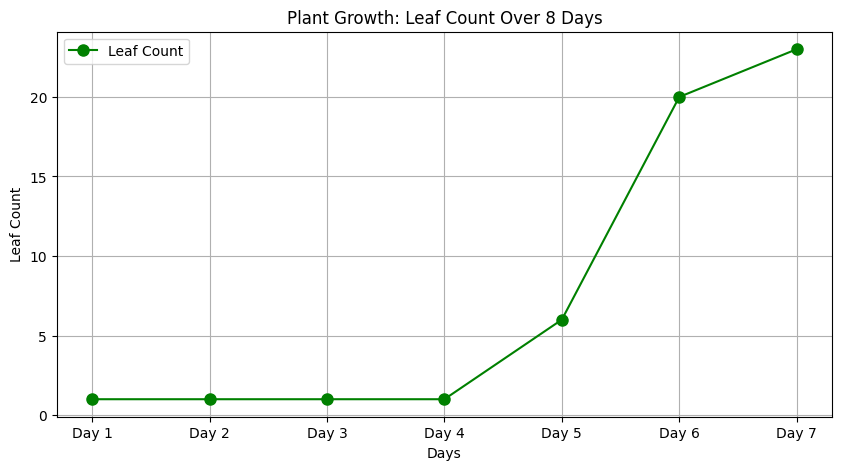

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

file_path = "images/"  # source
out_path = "images/output/"  # output

def image_enhance(image, output_path, filename):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # hsv to isolate green
    
    green_low = np.array([40, 40, 40])  # lower green boundary
    green_up = np.array([90, 255, 255])  # upper green boundary
    
    mask = cv2.inRange(hsv, green_low, green_up)  # binary mask
    
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # fill holes

    # Distance transform and thresholding for watershed
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)

    # Finding sure background area
    sure_bg = cv2.dilate(mask, kernel, iterations=3)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling for watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Ensure the background is not zero
    markers[unknown == 255] = 0  # Mark the unknown region

    # Apply Watershed
    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    image_copy[markers == -1] = [0, 0, 255]
    
    enhanced_path = os.path.join(output_path, "enhanced_images")
    os.makedirs(enhanced_path, exist_ok=True)
    
    out_file = os.path.join(enhanced_path, filename)
    cv2.imwrite(out_file, image_copy)
    if image_copy is not None:
        print(f"{filename} : Segmentation Success")
    else:
        print(f"{filename} : Unsuccessful segmentation")
    return sure_fg

def contour_draw(image, enhanced_image, output_path, filename):
    # find contours
    contours, _ = cv2.findContours(enhanced_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # draw contours
    contour_image = image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(contour_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        
    contour_path = os.path.join(output_path, "image_contours")
    os.makedirs(contour_path, exist_ok=True)
    
    out_file = os.path.join(contour_path, filename)
    cv2.imwrite(out_file, contour_image)
    if contour_image is None:
        print(f"{filename} : Error detecting leaves")
    else:
        print(f"{filename} : Detection success")
    
    leaf_count = max(len(contours), 1)  # Ensure minimum count of 1 for low detection cases
    print(f"\nNumber of Leaves in {filename} : {leaf_count}\n")
    
    return leaf_count

days = []
leaf_counts = []

for day in ['1', '2', '3', '4', '5', '6', '7', '8']:
    filename = f"day{day}_e_above.jpg"
    file = os.path.join(file_path, filename)

    image = cv2.imread(file)
    if image is None:
        print("Image not found:", file)
    else:
        print(f"{filename} successfully loaded")
        enhanced_image = image_enhance(image, out_path, filename)
        leaf_count = contour_draw(image, enhanced_image, out_path, filename) 
        
        days.append(f"Day {day}")
        leaf_counts.append(leaf_count)

# Plotting the leaf count over 8 days
plt.figure(figsize=(10, 5))
plt.plot(days, leaf_counts, marker='o', linestyle='-', color='g', markersize=8, label="Leaf Count")
plt.xlabel("Days")
plt.ylabel("Leaf Count")
plt.title("Plant Growth: Leaf Count Over 8 Days")
plt.xticks(days)  
plt.legend()
plt.grid(True)

# Save the plot
chart_output_path = os.path.join(out_path, "leaf_growth_chart.png")
plt.savefig(chart_output_path)
print(f"Growth chart saved to: {chart_output_path}")

# Show the plot
plt.show()
